# Reinforcement Learning-Value functions, Action-State functions, DQN and all that

Reinforcement learning (RL) is a task where we seek to find a machine learning algorithm that can sample/explore and interact with an enviornment in way that encourages actions towards a goal.  This is different from most machine learning tasks because in an RL problem, there is no labeled data set, in fact there is no data at all! This particular field of ML requires the algorithm to both generate data and exploit its generated data in order to drive the choices it makes towards some defined goal.  Naturally, with so little to start on in this problem we're going to need to formalize this problem and to this end RL is best described by Markov reward and Markov Decision processes (MRP/MDP).  In the following text we will touch on the mathematics of an MRP/MDP as well as demonstrating each step via some simple python scripts.  We will explore how an agent can influence an MDP and that the task of RL is seek the optimal influence in an MDP to accomplish a goal.  Ultimately we will be driving towards using neural networks as a form of approximate solution for optimal influence in any MDP and we will learn why that is nessecary.  The work will conclude with generating a neural network which will learn to balance an upright pendulum on a cart which has freedom to accelerate left or right in a single plane, amazingly we will not give the nueral network any information about physics to accomplish this task.  The outline of the work is given below.  

+ Markov Reward Process
+ Compact Mapping Theorem - Iterative Solution Details
+ Markov Decision process
+ Seeking the optimal policy
    - General Value Policy Improvement loop

+ Unknown transition probability MDP
+ Temporal difference learning
+ Q-learning
+ Large state spaces and approximate Q-learning
    - How Does One Solve For $\theta$?
    - Experience Replay and Target Networks
+ Conclusion

## 1. Markov Reward Process 

Lets start with the simplest version of a MDP, ie the Markov reward process (MRP). the MRP is simple Markov chain sequence, where we include rewards for each state transition. In a MRP there is no agency/influence for step to step transitions during the process.  Formally a Markov chain consists of a sequence of states $S=\{s_0,s_1,s_2,...,s_N\}$ which are sampled from a Markov process defined by a transition probability $P(s'|s)$ which gives the transition probability from state $s \rightarrow s'$. In a MRP, after each state $s$ to state $s'$ transition a reward dependent on the transition $r_{s',s}$ is sampled from $P(s',r|s)$.  Formally any sample sequence from an MRP has the form $S=\{(s_0,s_1,r_1),(s_1,s_2,r_2),...,(s_{N-1},s_N,r_N)\}$. For a particular sample sequence of the MRP the goal/long term reward of this sequence is computed after step $t$ by

$G({s_t,s_{t+1},s_{t+2},...,s_{T}}) = G_t = r_{t+1} + \gamma \ r_{t+2} + ...+\gamma^N \ r_{t+N} = \sum_{n=1}^{N} \gamma^n r_{t+n}$

Where $t+N=T$ is the terminal state of the sequence. We will denote any terminal state with $t=T$ from here on. The value of $t$ can be the initial step $t=0$ or any value in the sequence up to the terminal state step $t=T$, so that we can evaluate goals many times from one sequence. The long term reward also contains a parameter $\gamma$, called the discount factor, taken to be $0 \leq \gamma \leq 1$.  This parameter lets us control what is considered more import, immediate (state to state) rewards $\gamma \rightarrow 0$ or longer term over a whole sequence rewards $\gamma \rightarrow 1$.  With long term reward defined we can also define a value function $v(s)$ defined as the exception over all possible sequences of the MRP for the long term reward from any state $s$ onward to any terminal states.  This function is useful because it allows us to know on average how good is it to be in a state $s$ in terms of long term rewards.  We can compute this value on an MRP via 

$v(s) = \mathbb{E}\left[ G_t | s \right] = \sum_{s',r}P(s',r|s)\left(r +\gamma \sum_{s'',r'} P(s'',r'|s')(r' + \gamma \sum_{s''',r''}(...)\right)$

which can be expressed by the recursive function

$v(s) = \sum_{s',r} P(s',r|s)\left( r + \gamma \ v(s') \right)$

and simplified by defining the average instantaneous reward (reward given after each state transition) as

$r(s) = \sum_{s',r} P(s',r|s)r$

giving

$v(s) = r(s) + \gamma \sum_{s',r} P(s',r|s) v(s')$

This type of definition, with a finite number of states (values $s$ can take) allows us to express this relationship in terms of tensors ${\bf P}_{s,r,s'} = P(s',r|s)$ and ${\bf v}_s = v(s)$, ${\bf r}_s = r(s)$.  In cases where only one reward is possible from $s\rightarrow s'$ transitions, the transition tensor collapses to a standard matrix and we can solve the value function via simple matrix inversion

${\bf v} = ({\bf 1}-\gamma {\bf P})^{-1} {\bf r}$

Lets take a look at an example simple MRP and apply this inversion below.

In [40]:
# Simple Markov Reward Process
# solving the value function v(s) 
# when P(s',r|s) is known
import numpy as np
import pandas as pd

# this example is derived from David Silvers RL class

# Our process simulates the sequnce of attending 3 classes and passing the class
# where you then reach the terminal state sleep.  Some pitfalls are going on facebook
# or going to the bar which have non-zero probablities of returning to classes or 
# continuing on facebook.
cols = np.array(['class_1','class_2','class_3','pass_class','bar','facebook','sleep'])

# in the simplest cases P(s,r|s') decomposes to P(s'|s)R(s'|s)

# state to state transition probablity matrix P(s'|s)
# the rows are the current state s, and the columns
# the potential transition state s'
P=np.array([[0.0,0.5,0.0,0.0,0.0,0.5,0.0],
            [0.0,0.0,0.8,0.0,0.0,0.0,0.2],
            [0.0,0.0,0.0,0.6,0.4,0.0,0.0],
            [0.0,0.0,0.0,0.0,0.0,0.0,1.0],
            [0.2,0.4,0.4,0.0,0.0,0.0,0.0],
            [0.1,0.0,0.0,0.0,0.0,0.9,0.0],
            [0.0,0.0,0.0,0.0,0.0,0.0,1.0]])

# state to state reward matrix R(s'|s)
# passing the class and going to sleep is given
# +10 points all other actions are given negative
# rewards except going to the bar which has a minor
# +1 reward
R=np.array([[0.0,-2,0.0,0.0,0.0,-2.0,0.0],
            [0.0,0.0,-2.,0.0,0.0,0.0,-2.],
            [0.0,0.0,0.0,-2.,-2.,0.0,0.0],
            [0.0,0.0,0.0,0.0,0.0,0.0,10.],
            [1.0,1.0,1.0,0.0,0.0,0.0,0.0],
            [-1.,0.0,0.0,0.0,0.0,-1.,0.0],
            [0.0,0.0,0.0,0.0,0.0,0.0,0.0]])

# mean instanetous reward r(s)
r = np.matmul(P,R.T).diagonal()

# gamma value
y = 0.9

# solving the value function v(s) via matrix inversion
v = np.matmul(np.linalg.inv(np.eye(7)-y*P), r)

# print the value functions with their labels
valuefn_dict = dict(zip(cols,v))

# using pandas allows us to have a pretty output
value_df = pd.DataFrame(valuefn_dict.items(),columns=['state','v(state)'])
value_df.set_index('state')

,v(state)
state,
bar,1.908392
pass_class,10.000000
class_2,0.942655
class_3,4.087021
class_1,-5.012729
facebook,-7.637608
sleep,0.000000


Obviously being in the bar is good for the short term, but being in class 3 is much better as it is likely we will have the chance to pass the class.  Being in class 1 isn't so great as it has high likelyhood of moving to facebook which will not help us reach our ultimate goal.  Naturally this leads us towards the ability to make decisions on an MRP, ie infleunce which state to state transitions one takes, but before we do that lets discuss some methods of solving for a value function that do not involve matrix inversion.


## 2. Compact Mapping Theorem-Iterative Solution Details

Unfortunately the inversion of the matrices above can become a problem for other algorithms we will encounter so rather than inverting a matrix, we will use fixed point methods/iterative solutions.  We can use these methods when we satisfy the compact mapping theorem (CMT).  The CMT can be described below by first defining the Euclidean norm as

$||{\bf u}||=||u(s)|| = \sqrt{ \sum_s u(s)^2 }$

and we define a compact mapping function $T[{\bf v}]$ to be that of our value function condition
 
$T[v(s)] = r(s)+\gamma \sum_{s',r}P(s',r|s) v(s')$

If we look at two different vectors and how they are mapped to new vectors under $T$ we find

$||T(v)-T(u)|| = \gamma \sum_{s',r} ||P(s',r|s) (v(s')-u(s'))|| \leq \gamma ||{\bf v}-{\bf u}||$

Therefore if we define iterative values of the vector ${\bf v}$ as

$v^{k+1}(s) = T[ v^k(s) ]$

then after $k$ applications of the mapping function we have

$||T(v^k) - T(v^{k-1})|| \leq \gamma^k || {\bf v}^1 - {\bf v}^0||$

and because $|| {\bf v}^1 - {\bf v}^0||$ is finite and positive then as $k \rightarrow \infty$

we have

$T(v^\infty) = v^\infty$

Therefore the solution $v(s)$ we seek will be the fixed point of this process.  I demonstrate this below.

In [44]:
# solving the previous problem but using iterative solving method

# random initialization of the value function
v = np.random.randn(7)

# iterate until convergence as measured
# by delta
converge_delta = 0.001

# if it doesnt converge by the delta standard
# after MAX_ITERATIONS stop there
MAX_ITERATIONS = 1000
iterator = 0

# test for convergence with this
v_old = v 

continue_flag = True
while continue_flag or iterator == MAX_ITERATIONS:
    v = r + y*np.matmul(P,v)
    diff = (v - v_old)**2;
    # convergence checking condition
    if (not np.any(diff > converge_delta**2)):
        continue_flag = False
        print('converged -> steps: ',iterator)
    
    v_old = v
    iterator += 1
    
# print the value functions with their labels
valuefn_dict = dict(zip(cols,v))

# using pandas allows us to have a pretty output
value_df = pd.DataFrame(valuefn_dict.items(),columns=['state','v(state)'])
value_df.set_index('state')

('converged -> steps: ', 50)


,v(state)
state,
bar,1.912307
pass_class,10.003301
class_2,0.946171
class_3,4.090579
class_1,-5.007441
facebook,-7.630726
sleep,0.003301


## 3. Markov Decision Process

In a Markov decision process (MDP) we insert the ability to influence the state to state transition probability via an additional distribution $\pi(a|s)$ known as a policy.  This reflects the random sample of an action $a$ when in a state $s$ which impacts the state to state transition probability. We can now express its influence as

$P(s',r|s) \rightarrow P_\pi(s',r|s) = \sum_{a}P(s',r|s,a)\pi(a|s)$

Now we've introduced a distribution $P(s',r|s,a)$ which is the probability of transitioning from state $s$ to state $s'$ after performing action $a$ and receiving reward $r$.  With these modifications we can evaluate the value function $v(s)$ given our choice of policy function $\pi(a|s)$ expressed as 

$v[s,\pi(a|s)] = \mathbb{E}_\pi[ G_t| S_t = s]$

$v[s,\pi(a|s)] = \sum_{s',r,a} P(s',r|s,a)\pi(a|s)[ r+\gamma v[s',\pi(\cdot|s')] ]$

an alternative expression allows

$v_{\pi}(s) = \sum_a \pi(a|s) \left(\sum_{s',r}P(s',r|s,a)(r+\gamma v_{\pi}(s')\right)$

$v_{\pi}(s) = \sum_a \pi(a|s) q_{\pi}(s,a)$

Where now we've introduced a $q$ factor, known as a state-action return. Expressed in terms of a mean immediate reward given an action is

$r(s,a) = \sum_{s',r}P(s',r|s,a)r$

$q_{\pi}(s,a) = r(s,a) + \gamma \sum_{s',r} P(s',r|s,a)v_{\pi}(s')$

which allows the recursive expressions

$q_{\pi}(s,a) = r(s,a) + \gamma \sum_{s',r} P(s',r|s,a)\sum_{a'} \pi(a'|s') q_{\pi}(s',a')$

$v_{\pi}(s) = \sum_a \pi(a|s)r(s,a)+\gamma \sum_{s',r,a}P(s',r|s,a) \pi(a|s) v_{\pi}(s')$

$v_{\pi}(s) = r_{\pi}(s)+\gamma \sum_{s',r}P(s',r|s) v_{\pi}(s')$

The obvious question is how can we choose $\pi$ such that it maximizes all values of $v_\pi(s)$ for any $s$?  To answer that we must be able to evaluate $v_\pi(s)$ for any $\pi$ first.  That way we can determine which policys are better than others.  We can do so using the iterative method to solve for the fixed point of the above value function equations.  I demonstrate a fixed random policy evaluation below

In [146]:
# evalutating a policy v_pi(s) when a 
# random policy is used 
# and P(s',r|s,a) is known

# the example below is from an MDP in A. Geron
# Hands on Machine Learning with scikit learn
# and Tensorflow.  This MDP is 3 state system
# {s0,s1,s2}, where s0 has 3 available actions
# s1 has 2 available actions and s2 has 1 action
# available to it.  State s0 will give you a small
# reward if you stay there, but a large reward will
# be given if the agent can proceed to state s2 but
# it will have to overcome a penalty of transitioning
# from s1 to s2. NOTE THERE IS NO TERMINAL STATE HERE!
# LUCKILY THE GAMMA BEING LESS THAN 1 ALLOWS CONVERGENCE

# used to represent values that dont exist in the system
nan = np.nan

# again we decompose P(s',r|s,a)=P(s'|s,a)R(s'|s,a)
# P(s',r|s,a) transition probablities
P = np.array([#shape=[s,a,s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]]
    ])

# R(s'|s,a) rewards matrix
R = np.array([#shape=[s,a,s']
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]]
    ])

# actions avaliable per state
# shape=[s, action_space]
possible_actions = [[0,1,2],[0,2],[1]]

# setting the policy function pi(a|s) to random action
#shape=[s,a]
pi = np.full((3,3),nan)
for s,a in enumerate(possible_actions):
    pi[s,a] = 1./len(possible_actions[s])
    
# discount factor
y = 0.9

# compute the average instantous reward under policy pi
# r(s,a) = sum_s' P(s'|s,a)R(s'|s,a) -> sum( P[s,a,s'] R[s,a,s'], s'=0,2)
r_sa = np.array([[ np.sum((P*R)[s,a]) for a in range(3)]  for s in range(3)])

# r_pi = sum_a pi(a|s) r(s,a) -> sum( pi[s,a] r_sa[s,a],a = actions(s))
r_pi = np.array([ np.sum((pi*r_sa)[s,possible_actions[s]]) for s in range(3)])

# compute the state to state transition policy under the current policy P_pi(s'|s)
# sum_a P(s'|s,a)pi(a|s) -> sum( P[s,a,s']pi[s,a], a=actions(s))
P_s1s = np.array([[ np.sum(P[s,possible_actions[s],s1]*pi[s,possible_actions[s]]) for s in range(3)]  for s1 in range(3)])

# now we can iterate the v(s) function towards the fixed point
# using the same code as before

# random initialization of the value function
v = np.random.randn(3)

# iterate until convergence as measured
# by delta
converge_delta = 0.001

# if it doesnt converge by the delta standard
# after MAX_ITERATIONS stop there
MAX_ITERATIONS = 1000
iterator = 0

# test for convergence with this
v_old = v 

continue_flag = True
while continue_flag or iterator == MAX_ITERATIONS:
    v = r_pi + y*np.matmul(P_s1s,v)
    diff = (v - v_old)**2;
    # convergence checking condition
    if (not np.any(diff > converge_delta**2)):
        continue_flag = False
        print('converged -> steps: ',iterator)
    
    v_old = v
    iterator += 1
    
# print the value functions with their labels
valuefn_dict = dict(zip(['s0','s1','s2'],v))

# using pandas allows us to have a pretty output
value_df = pd.DataFrame(valuefn_dict.items(),columns=['state','v(state)'])
value_df.set_index('state')

('converged -> steps: ', 83)


,v(state)
state,
s2,26.278423
s1,-17.969924
s0,85.011930


## 4. Seeking the Optimal Policy

The optimal policy, $\pi(a|s)$, is the function such that we maximize the value function at each state

$v_*(s) = $max$_{\pi} v[s,\pi(a|s)]$

Translating the math to english, the optimal policy is one where at each state $s$ we choose the action that would result in the highest long term reward as parameterized by the $\gamma$ value.  Luckily we have such a function that we can determine which action would result in the maximal long term reward namely $a_*(s) = $argmax$_{a'} q_*(s,a')$.  Thus the optimal policy is one where $\pi(a_*(s)|s) \rightarrow 1$.  If for each state an optimal policy can be determined, ie there is no ties in the argmax function then the policy is said to be deterministic $pi(s) = a$.  The optimal policy can be expressed as  

$v_*(s) = $max$_a q_*(s,a)$

$q_*(s,a) = r(s,a) + \gamma \sum_{s',r} P(s',r|s,a)$max$_{a'}[ q_*(s',a') ]$

This recursive equation is essential to the concept of "Q-learning." More will be said on how to compute or learn the $q_*(s,a)$ table in more complex environments later on. For now we seek to determine $q_*(s,a)$, how can this be done when we know $P(s',r|s,a)$?  Again the iterative method will allow us to find a convergent solution, as is done below using our previous example.

In [154]:
# setting the q function q(s,a) to 0.0
# shape=[s,a]
Q = np.full((3,3),nan)
for s,a in enumerate(possible_actions):
    Q[s,a] = 0.0

# not going to test for convergence
for _ in range(MAX_ITERATIONS):
    Q_old = Q.copy() #we've got to make a copy or we'll be updating s,a values asychronusly
    for s in range(3):
        for a in possible_actions[s]:
            Q[s,a] = r_sa[s,a] + 0.95*np.sum( [ P[s,a,s1]*np.max(Q_old[s1,possible_actions[s1]]) for s1 in range(3) ] )

print(Q)
# the nan will interfer with our argmax so lets set all nan to -infinity
nan_idx = np.where(np.isnan(Q))
Q[nan_idx] = -np.infty

# find the optimal policy where we already know that there will be no ties
# in the Q values per state s
pi = np.argmax(Q,axis=1)
print('pi_*(s) = '+str(pi))

[[ 21.89925005  20.80428755  16.86759588]
 [  1.12082922          nan   1.17982024]
 [         nan  53.87349498          nan]]
pi_*(s) = [0 2 1]


## 4.1 General Value-Policy Improvement Loop

There also exists other methods of finding optimal policies. Most of all algorithms that find the optimal polices are ones which follow the general value-policy improvement loop (GVPL).  Typically we will start with a random policy compute the value function $v_\pi(s)$ then improve the policy by selecting transitions which would improve $v_\pi(s)$ for example, when in state $s$ looking at all possible transition $v_\pi(s')$ values, the optimal action is to move to the highest $v_\pi(s')$ as that will nessecarily improve your current $v(s)$ value (this is known as a greedy algorithm and may be sub-optimal). By repeating this process we will end up in a convergent result where we will have the optimal policy an optimal value function (may be local or global optima). There are various methods of execution of this loop but it should be fairly straight forward if you've followed the previous sections.  

What we're really interested in is MDPs where we do NOT know $P(s',r|s,a)$.  In these cases we have to use exploratory methods to try to empirically estimate $P(s',r|s,a)$ via Monte-Carlo sampling of sequences all while attempting to improve the policy as we gain new knowledge after each sequence. We explore these types of problems from here on.

## 5. Unknown Transition Probablity MDP

So how do we find the optimal policy when we do not know $P(s',r|s,a)$ but we can retrieve samples of the environment? In this case we use Markov chain monte carlo to simulate the environment, and use the large group of samples to make estimates of the exception values for the value function

$v_\pi(s) = \mathbb{E}[G_t|S_t=s]$

which can be estimated by $V(s)$ which is the empirical mean of all long term rewards $G_t$ received when state $s$ is encountered.  Following the GVPL we can then improve the policy until we find an optimal one so long as we're careful about not creating a bias in our policy that does not allow full exploration of the possible transitions for each state. The method we can use to update our estimate $V(s)$ is to use the fact that any mean can be updated via

$\mu_N = \frac{1}{N} \sum_{n=1}^N x_n = \frac{1}{N} ( (N-1)\mu_{N-1} + x_n ) = \mu_{N-1} + \frac{1}{N}(x_n - \mu_{N-1})$

Thus if we have a counter $N(s)$ which counts the number of times a state $s$ is visited in all sampled sequences referred to as episodes, we can update our estimate after each episode via 

$V(s) \rightarrow  V(s) +\frac{1}{N(s)}( G(s) - V(s))$

where $G(s)$ is the current episode long term reward observed for state $s$. It is important to note that updating the policy after each estimate value function update creates a bias towards the states already seen.  It's possible that there is a better action that just by chance we have not observed enough times to create a reliable estimate of $V(s)$ because of this bias it is important to continue to take random actions to throughly explore the entire state space.  However if we always act randomly, we may never find the optimal policy as we'll spend too much time exploring paths that lead to less than optimal outcomes.  So which do we do? Do we act greedy and always follow the best policy after an episode is observed? Or do we act randomly to explore the state space more throughly?  This tension is known as the explore-exploit problem, and is generally solved by always enforcing that the policy is non-deterministic and does not change too rapidly from episode to episode, or via the epsilon greedy algorithm. 

The epsilon greedy algorithm states that when an action is to be made, choose the current policies best action with probability $1-\epsilon$ and choose randomly from the possible actions with probability $\epsilon$.  This ensures a good trade off between exploring and exploiting, especially when one cools the epsilon value such that at the end of your updating you are nearly always acting according to the policy and almost never randomly.  There is still a danger of falling into a local optima but that is running theme for many machine learning processes.  Lets apply the GVPL to an environment using the OpenAI gym package.

In [995]:
# loading OpenAI GYM
import gym

# Here we're going to create an object
# that will store all the knowledge our
# agent gathers about its environment
# including it's policy and its state
# value function
class FL_agent():
    
    def __init__(self,env,epsilon_greedy=0.0):
        self.env = env
        
        self.S = env.observation_space.n
        self.A = env.action_space.n
        
        #initialize if this is going to be a deterministic
        #or probablistic policy (0.0 will use probablistic, any non 0.0 will be epsilon greedy)
        self.epsilon_greedy = epsilon_greedy
        
        #initialize value function, policy
        self.v = np.full(self.S,0.0)
        self.pi = np.full((self.S,self.A),1./self.A)
        
        #initialize states visit counter
        self.N = np.full(self.S,0)
    
    # define our agent's policy that will be used in the env
    # note that we assume the actions are discrete
    # and use an epsilon greedy algorithm and a probablistic
    # policy which can generalize to a deterministic one
    def policy(self,s):
        if np.random.random() >= self.epsilon_greedy:
            return int(np.random.choice(self.A,1,p = self.pi[s]))
        else:
            return np.random.randint(0,high=self.A)
    
    def value(self,s):
        return self.v[s]
    
    # update the estimated state value function
    # via the monte carlo method
    def update_v_MC(self,states_sample,rewards_sample,discount_rate):
        for t,s in enumerate(states_sample):
            discount_reward = np.sum([discount_rate**t1*r for t1,r in enumerate(rewards_sample[t::])])
            self.N[s] += 1
            self.v[s] += (discount_reward-self.v[s])/self.N[s]

    # update the agents policy given it's current
    # estimation of the value state function
    def update_policy(self,verbose=False):
        nrow = self.env.env.nrow
        ncol = self.env.env.ncol
        
        for row in range(nrow):
            for col in range(ncol):
                action_v = np.array([])
                for a in range(self.A):
                    row1,col1 = row,col
                    
                    if a==0: # left
                        col1 = max(col-1,0)
                    elif a==1: # down
                        row1 = min(row+1,nrow-1)
                    elif a==2: # right
                        col1 = min(col+1,ncol-1)
                    elif a==3: # up
                        row1 = max(row-1,0)
                
                    s = row*ncol + col
                    s1 = row1*ncol + col1
                                    
                    letter = self.env.env.desc.reshape(-1,)[s1]
                        
                    if letter == 'G':
                        r = 1.
                    else:
                        r = 0.
                        
                    # check if we fell in a hole or hit a wall
                    if letter == 'H' or s == s1:
                        act = 0.0
                    else:
                        act = self.v[s1]
                    
                    action_v = np.append(action_v,act)
             
                if verbose:
                    print('s: ',s,' action_v: ', action_v)
            
                if self.epsilon_greedy > 0.0:
                    one_hot_idx = np.argmax(action_v)
                    self.pi[s] = np.full(self.A,0.0)
                    self.pi[s,one_hot_idx] = 1.0
                else:
                    av_min = np.min(action_v)
                    av_max = np.max(action_v)

                    # handling the edge cases
                    if av_min == av_max:
                        if av_min == 0.0:
                            action_v = action_v+1.0
                        
                        self.pi[s] = action_v/np.sum(action_v)
                    else:
                        # the typical case
                        av_scaled = (action_v-av_min)/(av_max-av_min)+0.01
                        av_scaled = av_scaled/np.sum(av_scaled)
                        self.pi[s] = av_scaled
                
                    # another option is transforming the possible
                    # transition actions via a softmax function
                    # which is much less aggressive than the semi-greedy
                    # exp_a = np.exp(action_v)
                    # self.pi[s] = exp_a/np.sum(exp_a)
                
                

# make a function to simulate an episode
# that returns the sequence of transitions
# and the sequence of instanteous rewards
def sample_episode(env, policy):
    s = env.reset()
    states = []
    rewards = []

    done = False
    while not done:
        a = policy(s)
        s, R, done, _ = env.step(a)
        states.append(s)
        rewards.append(R)
    
    return(states, rewards)

In [ ]:
# the enviroment we're going to use
# is called FrozenLake (FL) but the built
# in OpenAI gym FL env has some random effects
# where after an action it is not deterministic
# that you arrive at the state you want
# to make things simplier here I create an env
# that is determinsitic to solve below
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

In [996]:
# creating our deterministic frozen lake env
env_FL0 = gym.make('FrozenLakeNotSlippery-v0')

# the objective is to go from S to G without falling
# into a H state (hole state) the rewards are -1 for all
# transitions thus the optimal policy is the shortest one

# the environment looks like
# SFFF  (S = start, F = frozen, H = hole, G = goal)
# FHFH
# FFFH
# HFFG

# possible actions at each state
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

In [997]:
# initialize our agent without 
# greedy epsilon policy
agent_FL = FL_agent(env_FL0)

# setting the max number of
# episodes we're going to 
# experience and the discount 
# factor
MAX_EPISODES = 5000
y = 0.95

# running the samples and updating
# the state value functions based
# on each episode
for episode in range(MAX_EPISODES):
    states,rewards = sample_episode(env_FL0, agent_FL.policy)
    agent_FL.update_v_MC(states,rewards,y)  
    
# after all the episodes are run
# reshape the state value function
# into the shape of the FL env
# so its easy to see state value functions
agent_FL.v.reshape(-1,4)

array([[ 0.00818649,  0.00725732,  0.01371626,  0.00857475],
       [ 0.00833559,  0.        ,  0.03502475,  0.        ],
       [ 0.01970781,  0.06654163,  0.12279926,  0.        ],
       [ 0.        ,  0.1613349 ,  0.42224334,  1.        ]])

In [1004]:
# okay so it looks like it works...
# lets run an epsilon greedy policy updating
# method first acting totally random epsilon = 1.0
# and we'll use a cooling acting more and more
# determinstic over each policy update
agent_FL = FL_agent(env_FL0,epsilon_greedy=1.0)

MAX_EPISODES = 10000
y = 1.0

for episode in range(MAX_EPISODES):
    states,rewards = sample_episode(env_FL0,agent_FL.policy)
    agent_FL.update_v_MC(states,rewards,y)
    
    # after experiencing 1000 epsiodes
    # update the internal policy using
    # an epsilon greedy algo, and then
    # cool the randomness of the policy
    if (episode+1) % 1000 == 0:
        agent_FL.update_policy()
        agent_FL.epsilon_greedy = agent_FL.epsilon_greedy*0.75

print('final epsilon: ',agent_FL.epsilon_greedy)

('final epsilon: ', 0.056313514709472656)


In [1005]:
# reminder of actions
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

# print out a visualization of the
# policy and state value functions
print('optimal determinisitic policy')
print('=============================')
print(np.argmax(agent_FL.pi,axis=1).reshape(-1,4))

optimal determinisitic policy
[[1 2 1 0]
 [1 1 1 0]
 [2 1 1 1]
 [2 2 2 0]]


In [1006]:
#evaluate the optimal state value function
optimal_deterministic_policy = agent_FL.pi

agent = FL_agent(env_FL0,epsilon_greedy=0.0)

MAX_EPISODES = 10000
y = 0.9

agent.pi = optimal_deterministic_policy

for episode in range(MAX_EPISODES):
    states,rewards = sample_episode(env_FL0,agent.policy)
    agent.update_v_MC(states,rewards,y)

In [1007]:
print('\noptimal value function, gamma = 0.9')
print('=====================================')
print agent.v.reshape(-1,4)


optimal value function, gamma = 0.9
[[ 0.       0.       0.       0.     ]
 [ 0.59049  0.       0.       0.     ]
 [ 0.6561   0.729    0.       0.     ]
 [ 0.       0.81     0.9      1.     ]]


In [1008]:
# cool so we got that to work
# the path always takes us to the
# goal, now let's check how this 
# works when the environment is not 
# determinsitic and we use a probablistic
# policy
env_FL0 = gym.make('FrozenLake-v0')

agent_FL = FL_agent(env_FL0)

MAX_EPISODES = 10000
y = 1.0

for episode in range(MAX_EPISODES):
    states,rewards = sample_episode(env_FL0,agent_FL.policy)
    agent_FL.update_v_MC(states,rewards,y)
    
    # update via the semi-greedy algo
    # every 500 epsiodes
    if (episode+1) % 500 == 0:
        agent_FL.update_policy()

In [1009]:
# reminder actions
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

print('optimal probablistic policy')
print('=============================')
print(agent_FL.pi.reshape(-1,4,4))

optimal probablistic policy
[[[ 0.00625406  0.63166007  0.35583181  0.00625406]
  [ 0.39065514  0.00591597  0.59751292  0.00591597]
  [ 0.16224953  0.68056815  0.15044402  0.0067383 ]
  [ 0.97115385  0.00961538  0.00961538  0.00961538]]

 [[ 0.00737894  0.74527281  0.00737894  0.23996931]
  [ 0.06506444  0.67495658  0.25329624  0.00668274]
  [ 0.00836315  0.84467779  0.00836315  0.13859591]
  [ 0.80589367  0.00797915  0.00797915  0.17814804]]

 [[ 0.00820791  0.00820791  0.82899903  0.15458515]
  [ 0.12710973  0.48257902  0.38553324  0.00477801]
  [ 0.22031965  0.67405318  0.00667379  0.09895337]
  [ 0.19667292  0.7877285   0.00779929  0.00779929]]

 [[ 0.00771587  0.00771587  0.77930253  0.20526574]
  [ 0.00735226  0.00735226  0.74257796  0.24271752]
  [ 0.19790612  0.00630494  0.63679879  0.15899016]
  [ 0.97115385  0.00961538  0.00961538  0.00961538]]]


In [1010]:
optim_prob_policy = agent_FL.pi

agent = FL_agent(env_FL0)

MAX_EPISODES = 10000
y = 0.9

agent.pi = optim_prob_policy

for episode in range(MAX_EPISODES):
    states,rewards = sample_episode(env_FL0,agent.policy)
    agent.update_v_MC(states,rewards,y)

In [1011]:
print('\noptimal value function, gamma = 0.9')
print('=====================================')
print agent.v.reshape(-1,4)


optimal value function, gamma = 0.9
[[ 0.00966806  0.00503765  0.01453033  0.00830083]
 [ 0.01361418  0.          0.03646097  0.        ]
 [ 0.03724576  0.09824627  0.12673554  0.        ]
 [ 0.          0.19015276  0.38571966  1.        ]]


## 6. Temporal Difference Learning

One disadvantage of the monte-carlo (MC) method is that entire episodes must be completed before we can update our value functions, and on top of that we have to wait for enough trails to find the expectation values for the policy updates.  For systems with huge state spaces these MC methods could take a very long time to complete even one episode!  Another issue with the MC method used above is that it assumes the environment is static, ie the environment doesn't evolve after each episode (formally this means that in a static enviornment $P(s',r|s,a)$ is fixed while it is not in non-static).  One obvious way to deal with non-static environments is to not update state value functions based on visit counts $N(s)$ but to use a moving or exponential average with a higher weight given to goals seen more recently such that our update equation becomes

$V(s) \rightarrow V(s) + \alpha \ (G(s) - V(s))$

where $0 < \alpha < 1$ so that terminal goals of recent episodes are more influential than past ones.  To address both the issue of non-stationary environments and potentially large state spaces we can use temporal differencing where we still estimate the state value function $V(s)$ but now we update during the episode via estimating the expected future return rather than computing the observed future return after a terminal state.  This means we will use MC methods to estimate

$v_\pi(s) = \mathbb{E}[r(S_t) + \gamma \ v_\pi(S_{t+1})|S_t=s]$

this modification allows us to write our MC updating method as

$V(s) \rightarrow V(s) + \alpha \ ( r(s) + \gamma \ V(s') - V(s) )$

where $s'$ is the observed transition state after action $\pi(a|s)$ is sampled.  This method is known as a TD(0) or temporal differencing order 0 method, from a class of differencing methods known as TD$(\lambda)$ methods.  It is import to note that in this method $V(s)$ is being updated by referencing itself, because of this, it is known as a bootstrapping method, and does not need to wait for a terminal state in order to update $V(S)$. Let's try this method out in the frozen lake environment to make sure it works.

In [981]:
class FL_agent_TD():
    
    def __init__(self,env,epsilon_greedy=0.0, alpha=0.8):
        self.env = env
        
        self.S = env.observation_space.n
        self.A = env.action_space.n
        
        #initialize if this is going to be a deterministic
        #or probablistic policy (0.0 will use probablistic, any non 0.0 will be epsilon greedy)
        self.epsilon_greedy = epsilon_greedy
        
        #initialize value function, policy
        self.v = np.full(self.S,0.0)
        self.pi = np.full((self.S,self.A),1./self.A)
        
        #initialize states visit counter
        self.N = np.full(self.S,0)
        
        # the non-stationary update rate
        self.alpha = alpha
        
    def policy(self,s):
        if np.random.random() >= self.epsilon_greedy:
            return int(np.random.choice(self.A,1,p = self.pi[s]))
        else:
            return np.random.randint(0,high=self.A)
    
    def value(self,s):
        return self.v[s]
    
    def update_v_MC(self,states_sample,rewards_sample,discount_rate):
        for t,s in enumerate(states_sample):
            discount_reward = np.sum([discount_rate**t1*r for t1,r in enumerate(rewards_sample[t::])])
            self.N[s] += 1
            self.v[s] += (discount_reward-self.v[s])/self.N[s]
    
    def update_v_TD0(self,s,R,s1,done,discount_rate):
            self.v[s] += self.alpha*(R+discount_rate*self.v[s1]-self.v[s])

    def update_policy(self,verbose=False):
        nrow = self.env.env.nrow
        ncol = self.env.env.ncol
        
        for row in range(nrow):
            for col in range(ncol):
                action_v = np.array([])
                for a in range(self.A):
                    row1,col1 = row,col
                    
                    if a==0: # left
                        col1 = max(col-1,0)
                    elif a==1: # down
                        row1 = min(row+1,nrow-1)
                    elif a==2: # right
                        col1 = min(col+1,ncol-1)
                    elif a==3: # up
                        row1 = max(row-1,0)
                
                    s = row*ncol + col
                    s1 = row1*ncol + col1
                                    
                    letter = self.env.env.desc.reshape(-1,)[s1]
                        
                    if letter == 'G':
                        r = 1.
                    else:
                        r = 0.
                        
                    # check if we fell in a hole or hit a wall
                    if letter == 'H' or s == s1:
                        act = 0.0
                    else:
                        act = r + self.v[s1]
                    
                    action_v = np.append(action_v,act)
             
                if verbose:
                    print('s: ',s,' action_v: ', action_v)
            
                if self.epsilon_greedy > 0.0:
                    one_hot_idx = np.argmax(action_v)
                    self.pi[s] = np.full(self.A,0.0)
                    self.pi[s,one_hot_idx] = 1.0
                else:
                    av_min = np.min(action_v)
                    av_max = np.max(action_v)

                    # handling the edge cases
                    if av_min == av_max:
                        if av_min == 0.0:
                            action_v = action_v+1.0
                        
                        self.pi[s] = action_v/np.sum(action_v)
                    else:
                        # the typical case
                        av_scaled = (action_v-av_min)/(av_max-av_min)+0.01
                        av_scaled = av_scaled/np.sum(av_scaled)
                        self.pi[s] = av_scaled

In [1030]:
# learning the optima via the TD(0) method
env_FL = gym.make('FrozenLake-v0')

agent_FL_TD = FL_agent_TD(env_FL,epsilon_greedy=1.0,alpha=0.7)

MAX_EPISODES = 10000
y = 0.9

# now we update as we run the episode
# as opposed to the MC method where 
# we run episodes then update
for episode in range(MAX_EPISODES):
    s = env_FL.reset()
    
    done = False
    while not done:
        a = agent_FL_TD.policy(s)
        s1, R, done, _ = env_FL.step(a)
        agent_FL_TD.update_v_TD0(s,R,s1,done,y)
        s = s1
        
        if (episode+1) % 5000 == 0:
            agent_FL_TD.update_policy()
            agent_FL_TD.epsilon_greedy = agent_FL_TD.epsilon_greedy*0.99

In [1031]:
# reminder actions
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

agent_FL_TD.update_policy()

In [1033]:
print(agent_FL_TD.v.reshape(-1,4))
print(np.argmax(agent_FL_TD.pi,axis=1).reshape(-1,4))

[[  1.58161318e-03   3.04584394e-04   2.75551747e-03   9.11480634e-04]
 [  4.87408480e-04   0.00000000e+00   4.24986571e-02   0.00000000e+00]
 [  1.58670762e-02   7.76891082e-02   8.60393896e-01   0.00000000e+00]
 [  0.00000000e+00   1.25522635e-01   9.76148452e-01   0.00000000e+00]]
[[1 2 1 0]
 [1 1 1 0]
 [2 2 1 1]
 [2 2 2 0]]


## 7. Q-Learning

All the methods discussed so far all make use of the GVPL to converge toward an optimal policy and state value function. When performing these iterations, we are continuously using the updated and improved policy to evaluate the the value function.  When we're using the actions of the policy to evaluate the optimality of the policy we say that this method is "on-policy."  However there does exists a method where we do not need to update the policy at all to find the optimal policy! Methods that do not need to follow the optimal policy in order to find it are called "off-policy."  The most useful off-policy method is that of Q-learning.  In Q-learning we're trying to learn through MC or TD methods the state-action value function $q_*(s,a)$ we've seen before in the fully known MDP section.  The optimal $q$ function was found to satisfy,

$q_*(s,a) = r(s,a) + \gamma \sum_{s',r} P(s',r|s,a)$max$_{a'}[ q_*(s',a') ]$

which will converge via iterative methods if $P(s',r|s,a)$ is known.  If we express this result in terms of expectation values

$q_*(s,a) = \mathbb{E}_\pi[ r(s,a) + \gamma \ $max$_{a'} q_*(s',a') ] $

we can combine the iterative method and MC or TD method to approximately solve $q_*(s,a)$ so long as we visit all $s,a$ pairs sufficiently using any method of sampling ie using ANY policy allows us to find $q_*(s,a)$ and thus the optimal policy!  Amazingly we can use any policy we like to estimate the true optimal policy.  This is like watching someone try every action repeately to try and accomplish a goal and noting which of those random actions eventually ended up in the best result.  After recording enough of the random events and their outcomes you can say which sequence of events is most likely to give you the best results.  

To ensure we sufficiently sample the $s,a$ space, which potentially can get stuck in non-fruitful areas of the state space, or simpley be too big to explore everything, we sample the relevant space in a timely manner by using a policy derived from the $q$ function.  We can use epsilon greedy and use the $q$ values to update a policy (making it on-policy again) or we can encourage the currently used policy to explore unseen or rarely visited state action pairs by tracking the number of visits to each state action pairs $N(s,a)$ and using a curiosity function $f(n)$ increase the probability of selecting the less visited states.  In fact we can combine a curiosity function with the $q$ function so that as we saturate part of the state space important to the $q$ function we can promote searching unvisited or rarely visited $s,a$ combinations using an epsilon greedy algorithm along with the modification

$q_{k+1}(s,a) \rightarrow r(s,a) + \gamma \ $max$_{a'} f(q_k(s',a'),N(s',a'))$ 

$f(q,n)= q + \frac{K}{1+n}$

with this modification and using an epsilon greedy policy only after all the adjoining actions of state $s'$ are sufficiently sampled will $q(s,a)$ converge. Lets try our some Q learning on a simple known MDP that does not have a terminal state (thus TD(0) is a good choice).

In [1411]:
# P(s',r|s,a) = P(s'|s,a)R(s'|s,a) transition probablities - pretend we don't know
# this but can sample from it
P = np.array([#shape=[s,a,s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]]
    ])

# R(s'|s,a) rewards matrix - pretend we don't know this
# but can sample it
R = np.array([#shape=[s,a,s']
    [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
    [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]]
    ])


# actions avaliable per state
# shape=[s, action_space]
possible_actions = [[0,1,2],[0,2],[1]]

# our discount level
y = 0.95
# our TD learning rate -
# level of influce from new
# observations on Q[s,a] states
alpha0 = 0.05

# how long should our sample be?
max_steps = 50000

# starting state
s = 0
# initialize Q,policy,visits counter
Q = np.full((3,3),-np.inf)
pi = np.full((3,3),0.)
N = np.full((3,3),0)

# we're also going to track
# variance of Q[s,a] states
# to see how accurate our 
# optimal Q estimate is
Q2 = np.full((3,3),-np.inf)
Qstd = np.full((3,3),0.0)

# initialization
for s,a in enumerate(possible_actions):
    Q[s,a] = 0.0
    Q2[s,a] = 0.0
    # random initial policy
    pi[s,a] = len(possible_actions[s])**-1.

# for visualizing the evolution of a Q[s,a] state
q = list()

# run the MDP
for k in range(max_steps):
    
    # encourage balancing the sampling of 
    # state-action pairs inversely propto
    # their visit count
    if k > 1000:
        for s in range(3):
            va = possible_actions[s]
            pi[s,va] = 1./N[s,va]/np.sum(1./N[s,va])
    
    # select the action
    a =  np.random.choice(range(3),p = pi[s])
    # determine the transition
    s1 = np.random.choice(range(3), p = P[s,a])
    
    # increase the visits count
    N[s,a] += 1
    # append the visual state value
    q.append(Q[1,2])
    # compute the online variance of states
    Q2[s,a] += ((R[s,a,s1] + y*np.max(Q[s1])) - Q[s,a])**2*alpha
    # compute the TD(0) update with fixed alpha
    Q[s,a] += (R[s,a,s1] + y*np.max(Q[s1]) - Q[s,a])*alpha
    # update the current state before relooping
    s = s1

estimated Q_*[s,a] table
[[ 22.02425757  21.3441346   19.26512742]
 [  2.6406052          -inf   4.26512792]
 [        -inf  53.64879869         -inf]]
TD(0) evolution of s=1,a=2 state


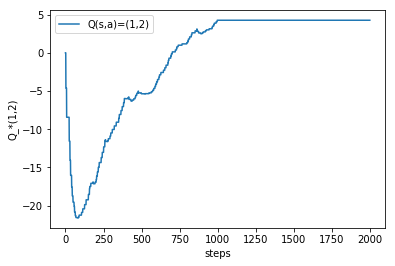

In [1416]:
import matplotlib.pyplot as plt
%matplotlib inline
print("estimated Q_*[s,a] table")
print("========================")
print(Q)

print("TD(0) evolution of s=1,a=2 state")
print("================================")
plt.plot(q[0:2000],label="Q(s,a)=(1,2)")
plt.legend()
plt.ylabel("Q_*(1,2)")
plt.xlabel("steps")
plt.show()

In [1415]:
print("Q Table Estimated Exponential Avg Std Deviation")
print("===============================================")
for s in range(3):
    for a in possible_actions[s]:
        Qstd[s,a] = np.sqrt(Q2[s,a])

print(Qstd)

Q Table Estimated Exponential Avg Std Deviation
[[   56.19578991     9.49458253    29.16436713]
 [    1.97969386     0.            27.05388686]
 [    0.          1213.77251657     0.        ]]


In [1417]:
print("Visits Counts - Should be Balanced")
print("==================================")
print(N)

Visits Counts - Should be Balanced
[[  211   214   231]
 [   98     0   119]
 [    0 49127     0]]


The visits do seem to be balanced, and we do happen to find the optimal deterministic policy by looking at $\pi_*(s) =$  argmax$_{a}q_*(s,a)$ that we found when the MDP transitions were known explicitly, however we see that the values for $q_*(s,a)$ we computed above are estimates of the true $q_*(s,a)$ and by looking at the evolution of the $q(1,2)$ value we see it has quite a large range of possible values depending on when we stopped the simulation.  This is also evidenced in standard deviation table.  This simply reflects that ultimately the reward for going to state 3 isn't that large compared to the penalty of transitioning to it, in fact depending on run to run of this method you might find other estimates would not suggest the optimal move is to move from $s=2 \rightarrow s=3$. So it is always important to view the variance of your estimates to get an idea of how accurate your estimate is.


## 8. Large State Spaces and Approximate Q-Learning

So far every method we've used has been tabular, ie we've constructed a tensor for $q,\pi,v$ values and determined optimal policies by updating tables.  We either solved the Bellman equation via an iterative or inverting method, or used a monte carlo method to find the values for $s,a$ pairs.  However when we start to consider larger environments, these methods quickly become computationally intractable. The space of $s,a$ pairs grows too large and becomes too time consuming to explore throughly not to mention the storage required as well.  So how do we apply our concepts we've learned to large state spaces?  This yet another example of the curse of dimensionality and is a great place to use a function approximate for $q(s,a) \approx q(s,a|\theta)$ where $\theta$ are tunable parameters. Through out the rest of this exploration of RL we'll focus on neural networks as our function approximator, though linear methods have been greatly explored.

To get our heads around this method let's consider the cart pole problem.  Here, we have a cart that is free to move left or right while an upright pendulum is attached to its center.  The goal is to balance the pendulum upright for as long as possible with the possible actions to accelerate left or accelerate right. The states for the system is a 4-tuple of cart position along one dimension, cart velocity, angular deviation from upright for the pendulum, and angular velocity

$s = (x,v,\alpha,\omega)$

now we're dealing with a continuous state space. The rewards for the system is $r = 1$ for each transition regardless of action so long as $|x|<$edge_limit and $|\alpha|<$tip_limit.  We will train a network choose an optimal action (accelerate left, accelerate right) given state $s$ as input.  For this task we'll use a fully connected 1 layer neural network to start with, where it will have the 4-tuple state as input and output $Q(s,a)$ for all actions possible (a 2-tuple in this case).  With one hidden layer our network is expressible as

$Q(s,\cdot|W,b) = W^{(2)}\cdot f(W^{(1)}\cdot s+b^{(1)}) + b^{(2)}$

where $W^{(i)}$ are the connection weight matrices, $b^{(i)}$ layer bias vectors, and $f$ our activation function.  Typically we would train a network on labeled data of the form $s \rightarrow Q_*(s,a)$ however we do not know the true $Q_*(s,a)$ we are trying to approximate but, however we can approximate the targets $Q_*(s,a)$ using the methods we developed in the previous sections! In order to find an estimate of the optimal $Q_*(s,a)$ function we can use $TD(0)$ learning to both run simulations of the environment and learn how to tune the estimator parameters towards the desired function, such that our estimator should approximately satisfy

$Q(s,a|\theta) \approx  \mathbb{E}_\pi[ r(s,a) + \gamma$ max$_{a'}( Q(s',a'|\theta) )]$

we can drive the estimator towards this approximate equality via TD sampling and using a loss function of the form

$L(\theta) = \frac{1}{2} ( Q(s,a|\theta) - [Q(s,a|\theta) + \alpha(r + \gamma$ max$_{a'}( Q(s',a'|\theta) ) - Q(s,a|\theta) )] )^2$  

$ = \frac{\alpha^2}{2} (r + \gamma$ max$_{a'}( Q(s',a'|\theta) ) - Q(s,a|\theta) )^2$

$L(\theta) \rightarrow \frac{1}{2} [r + \gamma$ max$_{a'}( Q(s',a'|\theta) ) - Q(s,a|\theta) ]^2$

where the arrow indicates this loss function also admits the optimal $Q_*(s,a)$ approximation, though not technically an equality. Now we can use standard optimization methods to drive $\theta$ towards the approximate equality.  Of course we want this to be minimized for all possible $(s,a,s',r)$-tuples over every possible episode sample $S_i$, ie we want to minimize

min$_\theta \ L(\theta) = $min$_\theta \ \frac{1}{2} \sum_{S_i} \sum_{t_i=0}^{t_{i,N}} [ r_{i,t} +\gamma \ $max$_{a'} \ Q(s'_{i,t},a_{i,t}|\theta) -  Q(s_{i,t},a_{i,t}|\theta) ]^2$

where $S_i=\left((s_0,a_0,s'_0,r_0)_i,(s_1,a_1,s'_1,r_1)_i,...,(s_T,a_T,s'_T,r_T)_i\right)$ is the $i$-th sample of the MDP.

## 8.1 How Does One Solve for $\theta$?

In principal one could simulate many sequences of an MDP, $\Sigma = \left(S_1,S_2,...,S_N\right)$ with $S_i=\left((s_0,a_0,s'_0,r_0)_i,(s_1,a_1,s'_1,r_1)_i,...,(s_T,a_T,s'_T,r_T)_i\right)$ and from this large collection of samples use gradient descent methods to minimize the loss function

$L(\theta) = \frac{1}{2} \sum_{S_i} \sum^{t_{i,N}}_{t_i=0} [r_{t,i} + \gamma$ max$_{a'}( Q(s'_{t,i},a'|\theta) ) - Q(s_{t,i},a_{t,i}|\theta) ]^2$

However in practice this does not tend to work very well, because although you're driving your approximation toward $Q_*(s,a)$ you have zero influence in the exporation method for $s,a$ pairs so for very large state spaces we will have to implement something closer to batch-stochastic gradient decent (bSGD) this way we can make a batch sample, and influence the sampling policy to explore more states of interest by optimizing 

$\mathfrak{L}(\theta,S_i) = \frac{1}{2} \sum^{t_{i,N}}_{t_i=0} [r_{t,i} + \gamma$ max$_{a'}( Q(s'_{t,i},a'|\theta) ) - Q(s_{t,i},a_{t,i}|\theta) ]^2$

Naturally, one might ask why not do SGD on every transition since the sum is commutive? In this case we're using transition based SGD optimization of

$l(\theta,s_{t,i},a_{t,i},s'_{t,i},r_{t,i}) = \frac{1}{2} [r_{t,i} + \gamma$ max$_{a'}( Q(s'_{t,i},a'|\theta) ) - Q(s_{t,i},a_{t,i}|\theta) ]^2$

Naturally because we're using SGD we'll have to use very small step sizes in any of our gradient desecnt methods.  Let's see an example of this method on the simple FrozenLake-v0 environment.

In [65]:
import gym
import numpy as np
# using Keras to build our function approximator
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializers import RandomUniform

env = gym.make('FrozenLake-v0')

# we're going to use a linear approximator for our Q(s,a) function
Q_approx = Sequential()
# use small random initialization of weights
rand = RandomUniform(minval=0.0, maxval=0.01, seed=None)
# dont include a bias, ie our model is Q(s,a) = s.W
Q_approx.add(Dense(4,input_shape=(16,),use_bias=False,activation="linear",kernel_initializer=rand))
# use gradient decent with step size fixed to 0.125
sgd = SGD(lr=0.125, momentum=0.0, decay=0.0, nesterov=False)
# using mean square error for optimization
Q_approx.compile(loss="mse",optimizer=sgd)

# discount reward factor
gamma = 0.9
# how random should we act when looking
# for optimal actions at the start?
epsilon_0 = 0.5
# how random should we act towards the
# end of all our simulations
epsilon_F = 0.001
# how many episodes should we sample?
max_episodes = 8000
# how many steps should we let an episode
# take before cutting it off?
max_T = 100

# we will use one hot encoding for our state
# vectors s = 1x16 vector with all zeros expect 1
# this is a collection of One Hot vectors
# where row 1 is the OHE for state 1
# row 2 is the OHE for state 2 and so on...
OHE_states = np.identity(16)

#goals list for eval
G_list = []
T_list = []

epsilon = epsilon_0

action_size = env.action_space.n

# start sampling the enviornment
for epi in range(max_episodes):
    s = env.reset()
    t = 0
    while t < max_T:
        t += 1
        #it wants something with same (1,16)
        #so add a lil more idx to give it 
        #the right shape
        OHE_s = OHE_states[s:s+1]
        #output shape is input rows X 4
        # in this case its (1,4)
        Q_s = Q_approx.predict(OHE_s)

        #epsilon greedy action selection
        if np.random.random() <= epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s[0])
        
        s1,r,d,_ = env.step(a)
        
        OHE_s1 = OHE_states[s1:s1+1]
        Q_s1 = Q_approx.predict(OHE_s1)
        max_a_Q_s1 = np.amax(Q_s1)
        target_Q_s = Q_s
        target_Q_s[0,a] = r + gamma*max_a_Q_s1
        
        # take a SGD step
        Q_approx.fit(OHE_s,target_Q_s,epochs=1,verbose=0)
        
        s = s1
        if d:
            break
    
    # cool the chances of random action
    epsilon = epsilon_0*(1.-epi/float(max_episodes)) + epsilon_F*(epi/float(max_episodes))
    G_list.append(r)
    T_list.append(t)
    
    # print status updates
    if (epi+1)%100 == 0:
        win_rate = np.sum(np.array(G_list[-20:]) > 0)/20.
        print("episode: {}/{} 20-Win rate: {} e: {:.3}".format(epi,max_episodes,win_rate,epsilon))

episode: 99/8000 20-Win rate: 0.05 e: 0.494
episode: 199/8000 20-Win rate: 0.0 e: 0.488
episode: 299/8000 20-Win rate: 0.0 e: 0.481
episode: 399/8000 20-Win rate: 0.0 e: 0.475
episode: 499/8000 20-Win rate: 0.0 e: 0.469
episode: 599/8000 20-Win rate: 0.15 e: 0.463
episode: 699/8000 20-Win rate: 0.05 e: 0.456
episode: 799/8000 20-Win rate: 0.05 e: 0.45
episode: 899/8000 20-Win rate: 0.05 e: 0.444
episode: 999/8000 20-Win rate: 0.05 e: 0.438
episode: 1099/8000 20-Win rate: 0.1 e: 0.431
episode: 1199/8000 20-Win rate: 0.0 e: 0.425
episode: 1299/8000 20-Win rate: 0.0 e: 0.419
episode: 1399/8000 20-Win rate: 0.05 e: 0.413
episode: 1499/8000 20-Win rate: 0.1 e: 0.406
episode: 1599/8000 20-Win rate: 0.1 e: 0.4
episode: 1699/8000 20-Win rate: 0.1 e: 0.394
episode: 1799/8000 20-Win rate: 0.05 e: 0.388
episode: 1899/8000 20-Win rate: 0.1 e: 0.382
episode: 1999/8000 20-Win rate: 0.05 e: 0.375
episode: 2099/8000 20-Win rate: 0.1 e: 0.369
episode: 2199/8000 20-Win rate: 0.1 e: 0.363
episode: 2299/8

In [66]:
# Reminder of the actions in this enviornment
#LEFT = 0
#DOWN = 1
#RIGHT = 2
#UP = 3

# Map of the frozen lake
#"SFFF"
#"FHFH"
#"FFFH"
#"HFFG"
 
# taking a look at the Q(s,.|W) ~ s.W model values 
print(Q_approx.get_weights()[0])

[[ 0.05688397  0.05396281  0.05403933  0.05401371]
 [ 0.03457741  0.04427769  0.04806162  0.05383124]
 [ 0.06173662  0.06222605  0.06925987  0.0584262 ]
 [ 0.03954676  0.04209962  0.03549012  0.05320517]
 [ 0.07550281  0.06198359  0.0616239   0.05638246]
 [ 0.00701722  0.00950799  0.00325666  0.00644062]
 [ 0.10785128  0.07275303  0.07295133  0.03393855]
 [ 0.00558792  0.0051061   0.00347821  0.00661942]
 [ 0.09020524  0.09174997  0.0761812   0.10470066]
 [ 0.16740301  0.24670726  0.19302788  0.12820294]
 [ 0.32204688  0.20449397  0.19328339  0.09719525]
 [ 0.00408718  0.00632348  0.00725746  0.00141312]
 [ 0.00674742  0.0009746   0.00157362  0.00152149]
 [ 0.21137629  0.30591199  0.40691161  0.29795143]
 [ 0.43196863  0.52086741  0.69714808  0.50644255]
 [ 0.00568838  0.00930547  0.00394364  0.00590765]]


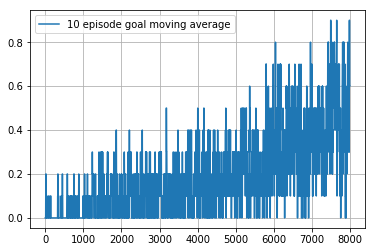

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Lets look at how the moving average of 10 eps 
# evolves using epsilon greedy actions and our
# function approximator to Q(s,a)
result = running_mean(G_list,10)
plt.plot(result,label="10 episode goal moving average")
plt.grid(True)
plt.legend()
plt.show()

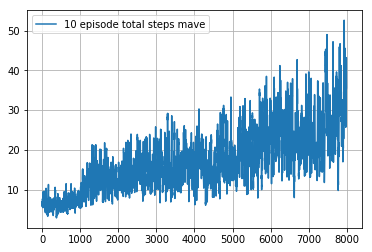

In [68]:
# lets also examen the 10 epsiode moving average 
# number of steps which are taken before a terminal
# state is encountered
result = running_mean(T_list,10)
plt.plot(result,label="10 episode total steps mave")
plt.grid(True)
plt.legend()
plt.show()

The linear approximation model  we used above,

$Q(s,a|W) = (s \cdot W)_a$ 

does pretty well at the end of 8000 simulations. It tends to find the goal even after taking a non-optimal number of steps (see the moving average of number of steps is increasing to above 20 at the same time the moving average goal is increasing).  However if you change any of the parameters in the model you will find that even after many steps there is no guarantee of convergence! If we didn't know this would work, we might spend ages looking for the right parameters and potentially conclude that this doesn't work if the approximator never did well. How do can we improve this?

## 8.2 Experience Replay and Target Networks

In the above algorithm you might have noticed we were using SGD to find the optimal approximator to the true $Q_*(s,a)$.  However to correctly use SGD you have to randomly sample from all possible points which are summed over in the loss function, ie randomly sample from $(s_{i,t},a_{i,t},r_{i,t},s'_{i,t})$ (see appendix A for a reminder on SGD) however the way we currently run the algorithm we do not sample independent experiences at each step, instead we're sampling highly correlated points.  In order to reduce the correlations between observations and obtain better convergence, one can use a method called experience replay.  In experience replay we store a history of observed $(s,a,r,s')$-tuples (experiences), when we update our function approximation we sample uniformly from all recorded observations this way our SGD is unlikely to have highly correlated sequences.


Another method that is used to improve convergence is to use target and prediction approximate functions to approximate the optimal $Q_*(s,a)$ function.  In the target and prediction function method we take optimization steps over a replay sample on a loss function given by

$L(\theta) = \frac{1}{2} \sum_{replay_i} \sum^{t_{i,N}}_{t_i=0} [r_{t,i} + \gamma$ max$_{a'}( Q(s'_{t,i},a'|\theta_t) ) - Q(s_{t,i},a_{t,i}|\theta_p) ]^2$

where $Q(s,a|\theta_t)$, the target function is an identical function approximator to $Q(s,a|\theta_p)$ but with different parameters $(\theta_t,\theta_p)$.  The optimization steps are done with respect to $\theta_p$ while $\theta_a$ is held fixed. If we slowly or periodically adjust $\theta_t$ toward $\theta_p$ values the SGD method tends to have better convergence behavior as the target our approximator is driving towards doesn't have as strong dependence on itself.  Other computational tricks have also been found in recent years such as replacing the term 

max$_{a'} Q(s'_{t,i},a'|\theta_t) \rightarrow Q(s'_{t,i},\ $argmax$_{a'}[ Q(s'_{t,i},a'|\theta_p)] \ |\theta_t)$

known as the double-DQN (DDQN) technique, one of many other numerical tricks employed today. Now that we're in possession of all these tricks and knowledge we're finally in a position to attempt to model the CartPole environment with approximate Q-learning techniques via a neural network as is done below.

In [68]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
# going to use an Adam optimizer this time
from keras.optimizers import Adam
from collections import deque
import random

# implementing an experience replay pool class
# we have to put some limit on the size
# as the memory is not inifinite, so we ask
# that we only store the most recent set of 
# experiences as the most revelent
class replay():
    def __init__(self,max_pool_size=2000):
        self.maxpool = max_pool_size
        self.memory_size = 0
        self.memory = deque(maxlen=self.maxpool)
    
    def add(self,event):
        self.memory.append(event)
        self.memory_size = len(self.memory)
    
    def sample(self,batch_size):
        sample_size = min(batch_size,self.memory_size)    
        return random.sample(self.memory,sample_size)

# implementing a DQN agent based on fully connected net
class DQNAgent(object):
    def __init__(self,env,hidden_dims=[[4,"relu"]]):
        # MDP problem variables
        self.gamma = 0.99
        # temp is used as epsilon or tempurature in
        # non deterministic policies with boltzmann
        # style policies
        self.Temp = 1.0
        self.Temp_min = 0.001
        self.cooling_rate = 0.995
        #when we use SGD methods we have to use very small 
        #steps which means really long run times
        self.lr = 0.005
        self.targ_rate = 0.001
        
        # Env variables
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.action_list = range(self.action_size)
        
        # Q Approximator variables
        self.hidden_dims = np.array(hidden_dims)
        
        #build fully connected (fc) networks
        #based on hidden dims variable
        self.Qtarg = self.build_fc_network()
        self.Qpred = self.build_fc_network()
        
        # Replay batch params
        self.batch_size = 32
        self.replay_pool = replay(max_pool_size=2000)
    
    # fully connected network builder
    def build_fc_network(self):
        model = Sequential()
        model.add(Dense(int(self.hidden_dims[0,0]), input_dim=self.state_size, activation=self.hidden_dims[0,1]))
        
        if len(self.hidden_dims) > 1:
            for hdim,fn in self.hidden_dims[1:]:
                model.add(Dense(int(hdim), activation=fn))
                
        model.add(Dense(self.action_size,activation='linear'))
        #im fixing the loss function to the Mean Square Errors (mse)
        #and to use an Adam optimizer
        model.compile(loss="mse", optimizer=Adam(lr=self.lr))
        return model
    
    def clone_target(self):
        #copy weights from predictions to target
        self.target.set_weights(self.predict.get_weights())
    
    def iterate_target_weights(self):
        # slowly use a learning rate type update
        # for the target network weights to progress
        # towards those of the prediction network
        W_update = []
        for w_t,w_p in zip(self.Qtarg.get_weights(),self.Qpred.get_weights()):
            temp = w_t + self.targ_rate*(w_p - w_t)
            W_update.append(temp)
            
        self.Qtarg.set_weights(W_update)
    
    # for non-deterministic policy selection
    def softmax_action(self,s):
        s_in = s.reshape(1,self.state_size)
        Qp_s = self.Qpred.predict(s_in)[0]
        # somtimes this has overflow issues 
        # using exp(number) so to stop this
        # we scale all the values so that
        # mathematically the result is the same
        # but the risk of overflow isnt there
        Qp_s = Qp_s - np.max(Qp_s)
        # clipping limit
        Qp_s[Qp_s < -10.] = -10
        softmax = np.exp(Qp_s/self.Temp)
        softmax = softmax/np.sum(softmax)
        return np.random.choice(self.action_list,p=softmax)
    
    # for epsilon greedy action selection
    def ep_greedy_action(self,s):        
        if np.random.random() < self.Temp:
            a = np.random.choice(self.action_list)
        else:
            s_in = s.reshape(1,self.state_size)
            Qp_s = self.Qpred.predict(s_in)[0]
            a = np.argmax(Qp_s)
        
        return a
    
    # experience based SGD method
    def fit_SGD_replay(self,use_DDQN=False):        
        batch = self.replay_pool.sample(batch_size=self.batch_size)
        #generate batch inputs and targets
        for s,a,r,s1,d in batch:
            s_in = s.reshape(1,self.state_size)
            MSE_target = self.Qpred.predict(s_in)
            if d:
                MSE_target[0,a] = r
            else:
                s1_in = s1.reshape(1,self.state_size)
                if use_DDQN:
                    targ = self.Qtarg.predict(s1_in)[0]
                    a1 = np.argmax(self.Qpred.predict(s1_in)[0])
                    targ = targ[a1]
                else:
                    targ = np.max(self.Qtarg.predict(s1_in)[0])
                
                MSE_target[0,a] = r + self.gamma*targ
            
            self.Qpred.fit(s_in,MSE_target,epochs=1,verbose=0)
        
        if self.Temp > self.Temp_min:
            self.Temp *= self.cooling_rate
    
    # mini batch experience replay SGD method
    def fit_bSGD_replay(self,use_DDQN=False):        
        batch = self.replay_pool.sample(batch_size=self.batch_size)
        s_in_vect = []
        t_vect = []
        #generate batch inputs and targets
        for s,a,r,s1,d in batch:
            s_in = s.reshape(1,self.state_size)
            MSE_target = self.Qpred.predict(s_in)
            if d:
                MSE_target[0,a] = r
            else:
                s1_in = s1.reshape(1,self.state_size)
                if use_DDQN:
                    targ = self.Qtarg.predict(s1_in)[0]
                    a1 = np.argmax(self.Qpred.predict(s1_in)[0])
                    targ = targ[a1]
                else:
                    targ = np.max(self.Qtarg.predict(s1_in)[0])
                
                MSE_target[0,a] = r + self.gamma*targ
            
            s_in_vect.append(s_in[0])
            t_vect.append(MSE_target[0])
        
        s_in_vect = np.array(s_in_vect)
        t_vect = np.array(t_vect)
        self.Qpred.fit(s_in_vect,t_vect,epochs=1,verbose=0)
        
        if self.Temp > self.Temp_min:
            self.Temp *= self.cooling_rate

In [69]:
env = gym.make("CartPole-v1")

# run time parameters
max_episodes = 7000
print_int = 500
max_episode_length = 1000
# dont start any training until
# a few samples have been taken 
# to avoid any bias towards
# certain actions
pre_train_size = 100
R_record = []
# goign to use 1 hidden layer with 16 units with relu activations
agent = DQNAgent(env=env,hidden_dims=[[16,"relu"]])

# start totally random
agent.Temp = 1.0
# and cool to pretty deterministic
agent.Temp_min = 0.1
agent.cooling_rate = agent.Temp_min**(1./max_episodes)
print('Initial Temp: ', agent.Temp)
print('Minimum Temp: ', agent.Temp_min)
print('Exponential Cooling Rate: ', agent.cooling_rate)
print('Starting Env Simulation -- Max Episodes: ', max_episodes)
print('--------------------------------')

for episode in range(max_episodes):
    s = env.reset()
    for t in range(max_episode_length):
        a = agent.ep_greedy_action(s)
        #a = agent.softmax_action(s)
        s1,r,d,_ = env.step(a)
        # adding a penalty for going too close to the walls which is
        # at +-2.4 distance units
        r = r + 0.00*(1./(s1[0]-2.4)**5 - 1./(s1[0]+2.4)**5+2./(2.4**5))
        agent.replay_pool.add((s,a,r,s1,d))    
        s = s1
        if d:
            agent.iterate_target_weights()
            break
    
    # lets avoid making any changes until the pool
    # fills with a few samples
    if episode > pre_train_size:
        agent.fit_bSGD_replay(use_DDQN=False)
    
    if episode%10 == 0:
        R_record.append(t)
        
    if (episode+1) % print_int == 0:
        print("episode: {}/{}, score: {}, Temp:{:.3}".format(episode+1,max_episodes,t,agent.Temp))
    
print("completed episodes")
print("mean reward: ", np.mean(R_record))
print("mean stddev: ", np.std(R_record))
print("last 10: ", R_record[-10:-1])

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
('Initial Temp: ', 1.0)
('Minimum Temp: ', 0.1)
('Exponential Cooling Rate: ', 0.999671113367499)
('Starting Env Simulation -- Max Episodes: ', 7000)
--------------------------------
episode: 500/7000, score: 39, Temp:0.877
episode: 1000/7000, score: 10, Temp:0.744
episode: 1500/7000, score: 8, Temp:0.631
episode: 2000/7000, score: 15, Temp:0.535
episode: 2500/7000, score: 9, Temp:0.454
episode: 3000/7000, score: 38, Temp:0.385
episode: 3500/7000, score: 12, Temp:0.327
episode: 4000/7000, score: 13, Temp:0.277
episode: 4500/7000, score: 71, Temp:0.235
episode: 5000/7000, score: 87, Temp:0.2
episode: 5500/7000, score: 106, Temp:0.169
episode: 6000/7000, score: 97, Temp:0.144
episode: 6500/7000, score: 171, Temp:0.122
episode: 7000/7000, score: 137, Temp:0.103
completed episodes
('mean reward: ', 61.304285714285712)
('mean stddev: ', 67.822375017845147)
('last 10: ', [167, 141, 256, 243, 118

In [46]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

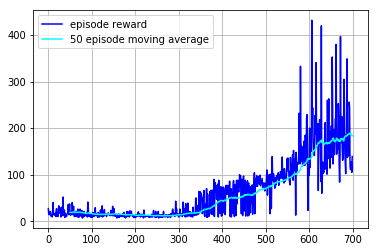

In [70]:
# plot the rewards every 10 epsiodes and the moving average
# of the rewards as the simulation runs
plt.plot(range(len(R_record)),R_record,color='blue',label='episode reward')

moving_ave = running_mean(R_record,50)
mv_x = [(x+50) for x in range(len(moving_ave))]

plt.plot(mv_x,moving_ave,color='cyan',label='50 episode moving average')
plt.grid(True)
plt.legend()
plt.show()

## 9. Conclusion

Finally we're at the point where we are able to create an agent who can perform a fairly complex task with no information about its environment but solely by gathering it's own data and knowing what it's goal is, can learn to perform optimally.  Reinforcement learning continues to be an active area of research today, and many groups are attempting to find improvements to these deep neural network training algorithms. There are many more methods to explore such as policy gradients, and the very successful actor-critic models. Many blogs and articles can be found on this subject today and I encourage you to look for information on these topics.  The OpenAI gym contains many more environments to explore and problems to solve and I encourage you to explore them.  Good luck and thank you.

# Appendix A
## Stochastic Gradient Descent

Let's remind ourselves how the stochastic gradient descent method works, and why it works.  When trying to optimize a scaler function given by a sum of terms, $f(\theta) = \sum_{n=1}^N f_n(\theta)$ the gradient decent algorithm for minimizing $f(\theta)$ is accomplished via repeated use of

$\theta_{k+1} = \theta_k - \alpha \ \partial_\theta f(\theta_k)$

which results in

$f(\theta_{k+1}) \approx f(\theta_k) - \alpha \ \left( \partial_\theta f(\theta_k) \right)^2 < f(\theta_k)$ so long as
$\alpha \ \left(\partial_\theta f(\theta_k) \right)^2 \ll f(\theta_k)$

therefore so long as $\alpha$ remains sufficiently small repeated updating of the $\theta$ parameters always moves you to a smaller value of $f(\theta)$. In stochastic gradient decent (SGD) our iteration rule is modified by 

$\theta_{k+1} = \theta_k - \alpha' \ \partial_\theta f_j(\theta_k)$

where $j$ runs from $(1,N)$ successively.  The question is after many applications of this iteration policy, do we minimize $f(\theta)$? Let's consider $f(\theta_M)$ vs. $f(\theta_0)$ by evaluating $\theta_M$ for some $0 < M$. 

$\theta_1 = \theta_0 - \alpha' \ \partial_\theta f_{1}(\theta_0)$

$\theta_2 = \theta_1 - \alpha' \ \partial_\theta f_{2}(\theta_1)$

$=\theta_0 - \alpha' \ \partial_\theta f_{1}(\theta_0) - \alpha' \ \partial_\theta f_{2}(\theta_0) +O(\alpha'^2)$

...

$\theta_M = \theta_0 - \alpha' \left( \partial_\theta f_{1}(\theta_0)+\partial_\theta f_{2}(\theta_0)+...+\partial_\theta f_{M}(\theta_0)\right) + O(\alpha^2)$

...

$\theta_N=\theta_0 - \alpha' \ \partial_\theta \left( \sum_{n=1}^N f_n(\theta_0) \right) + O(\alpha'^2)$

$=\theta_0 - \alpha' \ \partial_\theta f(\theta_0) + O(\alpha^2)$

We see that $\theta_N$ is approximately the same as evaluating a single step of the full batch gradient decent so long as $\alpha' \ll \alpha$.  Thus running this iteration algorithm for many more times than the size of the data set will allow you to find the same optima as the full batch results.  However, one might ask is it necessary that I use every $f_j(\theta)$ to accomplish this same goal?  The answer is no, this is obvious when one considers when doing the full batch gradient descent method, the step for $\theta_k$ is given by

$\delta \theta_k = -\alpha \ \partial_\theta \left( \sum_j f_j(\theta_k) \right)$

$ = -\alpha \ \left(\partial_\theta f_1(\theta_k) + ... + \partial_\theta f_N(\theta_k) \right)$

The expansion suggests that each function $f_j(\theta_k)$ "votes" on how to adjust the parameter $\theta_k$ all of the votes are summed and the step is taken.  Consider if many of $f_j(\theta)$ are already near their minimum they would vote not to move very much at all while a single vote that is far from its particular optima will try to adjust the parameters, the act of this gradient descent is to balance these votes so that every function gets as close to their optima as possible.  In this view rather than sum up all votes, if we only sum a small batch of votes that are taken UNIFORMLY and making smaller adjustments ie $\alpha' < \alpha$ then we will drive towards the global optima (the balance of votes) if we repeat this iterative procedure.  Of course the size of the step will depend on the size of the sample of votes, thus as you use fewer and fewer votes to decide the parameter adjustment you must use smaller and smaller steps to ensure convergence.

Note that the uniform sampling of votes is cruicual to letting this method work.  If we took samples from highly correlated functions and took many steps based on these functions then we would drive ourselves away from the optima and cause us to never converge on an optimal parameter as we would repeatly be moving towards a group's votes then another group of correlated functions votes and a cycle would be established.